In [2]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy import constants
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support
#Move up to RAFTS directory

from tqdm import tqdm

In [3]:
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('..')
from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, find_min_max_adjacent, variance_weighted_mean, chrDistAng
import globals

from config import *


In [ ]:

from photutils.psf import IntegratedGaussianPRF, PSFPhotometry
from photutils.detection import DAOStarFinder
from photutils import CircularAperture
from photutils.background import MMMBackground, LocalBackground


In [10]:
D2ARCSEC = 3_600
DAY2SEC = 24 * 3_600
flr_id = 11

In [5]:
#PARAMS
flare_ref_pos = np.array([323.0, 429.5])

filters = ['u', 'g', 'r', 'i', 'z', 'y']

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

In [ ]:
hdu_list = fits.open('dwfflare/0a7936112f3150350b27277900f88de2_c4d_151218_061807_ooi_g_v1.fits.fz')
hdu_list.info()

Filename: /Users/riley/Desktop/RAFTS/dwfflare/0a7936112f3150350b27277900f88de2_c4d_151218_061807_ooi_g_v1.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   ()      
  1  S29           1 CompImageHDU    129   (2046, 4094)   float32   
  2  S31           1 CompImageHDU    129   (2046, 4094)   float32   
  3  S25           1 CompImageHDU    129   (2046, 4094)   float32   
  4  S26           1 CompImageHDU    129   (2046, 4094)   float32   
  5  S27           1 CompImageHDU    129   (2046, 4094)   float32   
  6  S28           1 CompImageHDU    129   (2046, 4094)   float32   
  7  S20           1 CompImageHDU    129   (2046, 4094)   float32   
  8  S21           1 CompImageHDU    129   (2046, 4094)   float32   
  9  S22           1 CompImageHDU    129   (2046, 4094)   float32   
 10  S23           1 CompImageHDU    129   (2046, 4094)   float32   
 11  S24           1 CompImageHDU    129   (2046, 4094)   float32   
 12  S14      

In [4]:
flare = pd.read_csv("Outdata/flare_df.csv")#, names=["mjd", "dpar_detrended")
flare = flare.sort_values(by="mjd")
dpar_arr = np.load("Outdata/dpar_arr.npy")

In [14]:
imnames_timeordered = np.load('Outdata/imnames_timeordered.npy')
main_df = pd.read_csv("Outdata/main_df.csv")#, names=["mjd", "dpar_detrended")

t_index = []
for i, time in enumerate(main_df['time'].dropna().unique()):

    if (main_df['time'][main_df['id'] == flr_id].values == time).any():
        t_index.append(True)

    else:
        t_index.append(False) 
        
g_flux = main_df[main_df['id'] == flr_id]['flux_fit']
g_flux_err = main_df[main_df['id'] == flr_id]['flux_err']
flr_times = main_df[main_df['id'] == flr_id]['time']
g_mag = 22.5 - 2.5 * np.log10(g_flux.values)
g_mag_err = (2.5/np.log(10)) * (g_flux_err/g_flux)
g_mag_err = g_mag_err.values
delta_g_mag = g_mag - np.mean(g_mag[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000])
delta_g_mag_err = g_mag_err - np.sqrt(np.sum(g_mag_err[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000] ** 2)) /  len(g_mag_err[((flr_times - flr_times.iloc[0]) * DAY2SEC) < 1000])


for i, t in enumerate(t_index):
    if not t:
        delta_g_mag = np.insert(delta_g_mag, i, np.nan)
        delta_g_mag_err = np.insert(delta_g_mag_err, i, np.nan)
    else:
        pass

delta_g_mag, delta_g_mag_err

(array([ 4.50540586e-02,             nan,             nan,  6.18003671e-02,
        -2.75031746e-01,  1.53599598e-01,  5.28521951e-02, -2.06404632e-01,
         9.97016979e-02, -1.09199890e-01,  9.59371004e-02, -1.93514136e-02,
                    nan,  1.02343554e-01,  1.59777841e-02,             nan,
                    nan,  5.61083883e-03,  1.00573270e-01, -7.53870994e-02,
        -4.80756832e-02, -1.78392940e-02,  1.22433058e-02,  2.76158036e-01,
                    nan,  2.72314214e-01,  3.80101782e-01, -2.86631927e-01,
         1.46376557e-03, -3.65414442e-01, -6.12486939e+00, -5.82499183e+00,
        -5.41354601e+00, -5.03078173e+00, -4.55342130e+00, -4.17228568e+00,
        -3.89542434e+00, -3.66042475e+00, -3.33475428e+00, -3.13259622e+00,
        -2.91099073e+00, -2.74375166e+00, -2.54332689e+00, -2.41273437e+00,
        -2.29597276e+00, -2.15847218e+00, -1.98008144e+00, -1.94049208e+00,
        -1.87694650e+00, -1.77485261e+00, -1.62054447e+00, -1.73878246e+00,
        -1.7

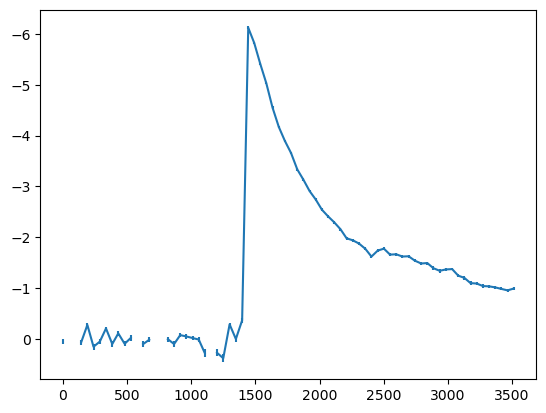

In [15]:
times = main_df['time'].dropna().unique() 
# you were doing this subtraction and the conversion to second 50 times and then you were creating this variable way below...
tSec = (times - times[0]) * DAY2SEC
plt.errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err)
plt.gca().invert_yaxis()

In [ ]:
#Collect DATE-OBS list
datelist = []

for i, imname in enumerate(imnames):
    try:
        image_header = fits.getheader('dwfflare/' + imname, ext=0)
        datelist.append(image_header['DATE-OBS'])

    except:
        print(i, 'EXT not found')
        datelist.append(image_header['DATE-OBS'])

datearr = np.array(datelist)

44 EXT not found
129 EXT not found


In [17]:
start = 8
end = 82

In [18]:
times = np.array([time.mjd for time in times[start:end]])

In [66]:
ras = np.zeros((74, 110))
decs = np.zeros((74, 110))


for i, t in enumerate(main_df['time'].dropna().unique()):
    for j, id in enumerate(np.sort(main_df['id'].dropna().unique())):

        if main_df['RA'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values:
            ras[i,j] = main_df['RA'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values
            decs[i,j] = main_df['DEC'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values

        else:
            ras[i,j] = np.nan
            decs[i,j] = np.nan

np.save('Outdata/ras.npy', ras)
np.save('Outdata/decs.npy', decs)

In [67]:
raerrs = np.zeros((74, 110))
decerrs = np.zeros((74, 110))


for i, t in enumerate(main_df['time'].dropna().unique()):
    for j, id in enumerate(np.sort(main_df['id'].dropna().unique())):

        if main_df['RA_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values:
            raerrs[i,j] = main_df['RA_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values
            decerrs[i,j] = main_df['DEC_ERR'][(main_df['id'] == id) * (main_df['time'] == t)].dropna().values

        else:
            raerrs[i,j] = np.nan
            decerrs[i,j] = np.nan

np.save('Outdata/raerrs.npy', raerrs)
np.save('Outdata/decerrs.npy', decerrs)

In [44]:
ras.shape, decs.shape

((74, 110), (74, 110))

# Rubin Pipeline v19 Processed Data

In [ ]:
data = pd.read_csv('dwfflare_rubin_v19/DiaSource.csv')

In [ ]:
data = data.sort_values('midPointTai')
data.head()

Unnamed: 0         diaSourceId  ccdVisitId         diaObjectId  \
124         124  216103070499602478    50315417  216108224460357684   
125         125  216103070499602479    50315417  216116814394949683   
127         127  216103070499602481    50315417  216103070499602481   
128         128  216103070499602482    50315417  216116814394949687   
129         129  216103070499602483    50315417  216116814394949688   

     ssObjectId  parentDiaSourceId  prv_procOrder  ssObjectReassocTime  \
124           0                  0              0                  NaN   
125           0                  0              0                  NaN   
127           0                  0              0                  NaN   
128           0                  0              0                  NaN   
129           0                  0              0                  NaN   

      midPointTai         ra  ...    ixxPSF    iyyPSF    ixyPSF  extendedness  \
124  57374.241476  45.555622  ...  3.426724  4.026059 -0.236854           NaN   
125  57374.241476  45.576322  ...  3.426724  4.026059 -0.236854           NaN   
127  57374.241476  45.633935  ...  3.426724  4.026059 -0.236854           NaN   
128  57374.241476  45.648674  ...  3.426724  4.026059 -0.236854           NaN   
129  57374.241476  45.645419  ...  3.426724  4.026059 -0.236854           NaN   

     spuriousness     flags  pixelId  filterName  filterId  isDipole  
124           NaN  25299404        0           g         1         0  
125           NaN  25165824        0           g         1         0  
127           NaN  25166620        0           g         1         0  
128           NaN       828        0           g         1         1  
129           NaN  25165824        0           g         1         0  

[5 rows x 112 columns]

In [ ]:
print(data.columns[:20])

Index(['Unnamed: 0', 'diaSourceId', 'ccdVisitId', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'prv_procOrder', 'ssObjectReassocTime',
       'midPointTai', 'ra', 'raErr', 'decl', 'declErr', 'ra_decl_Cov', 'x',
       'xErr', 'y', 'yErr', 'x_y_Cov', 'apFlux'],
      dtype='object')


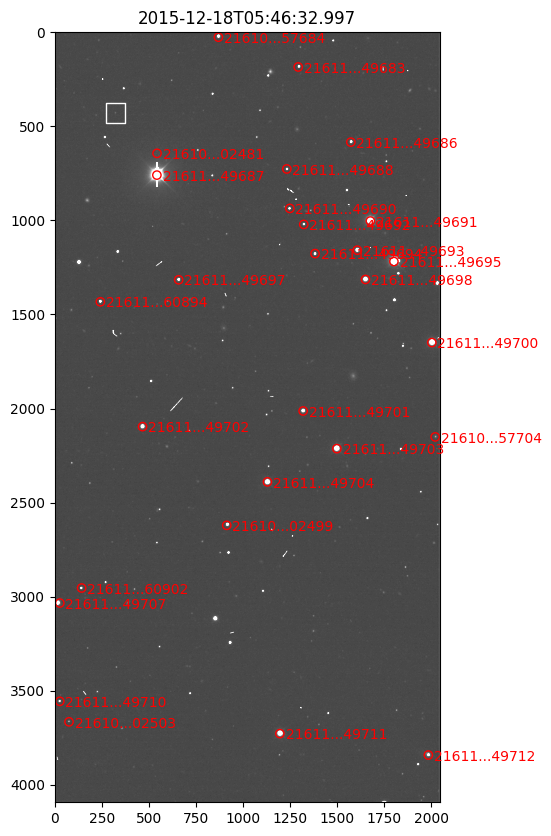

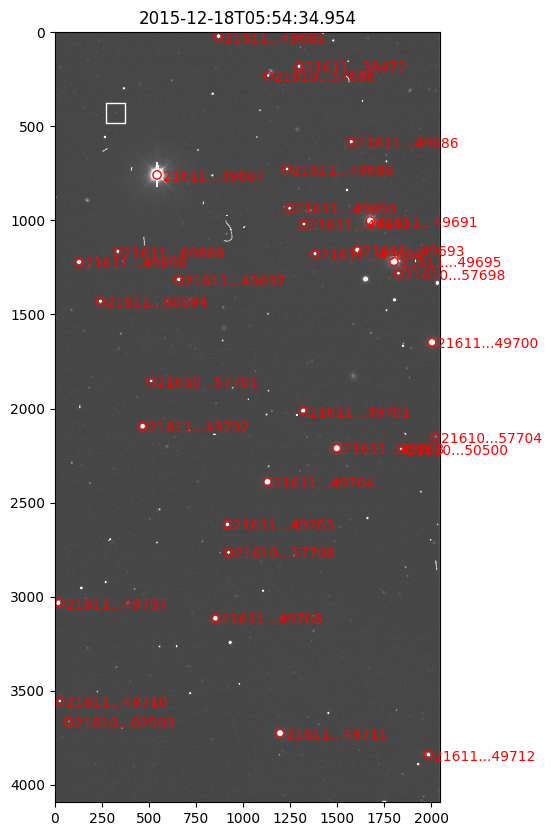

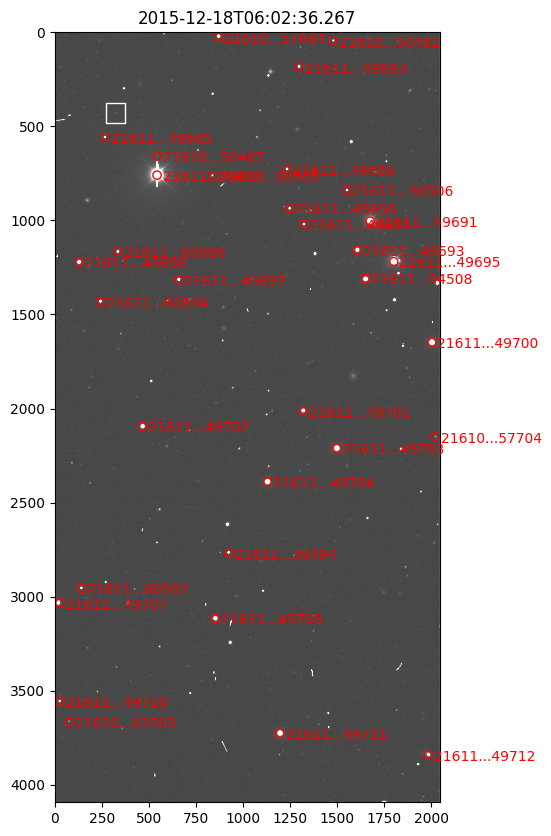

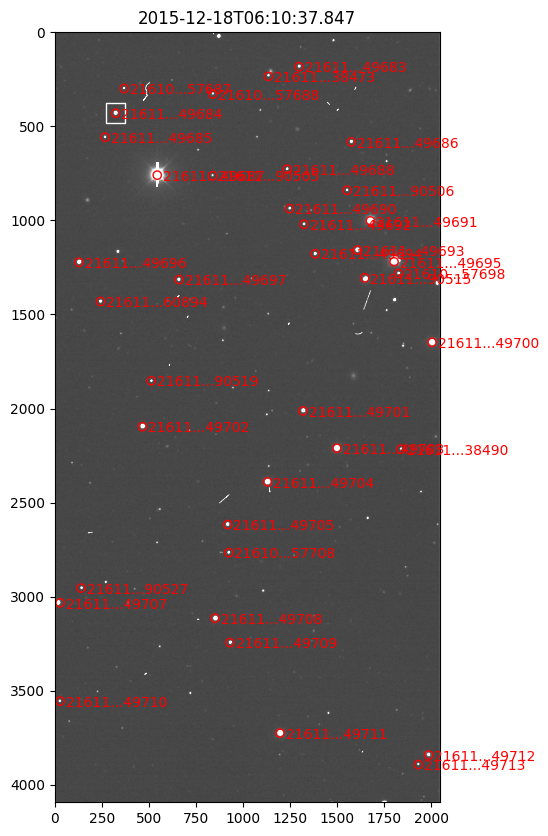

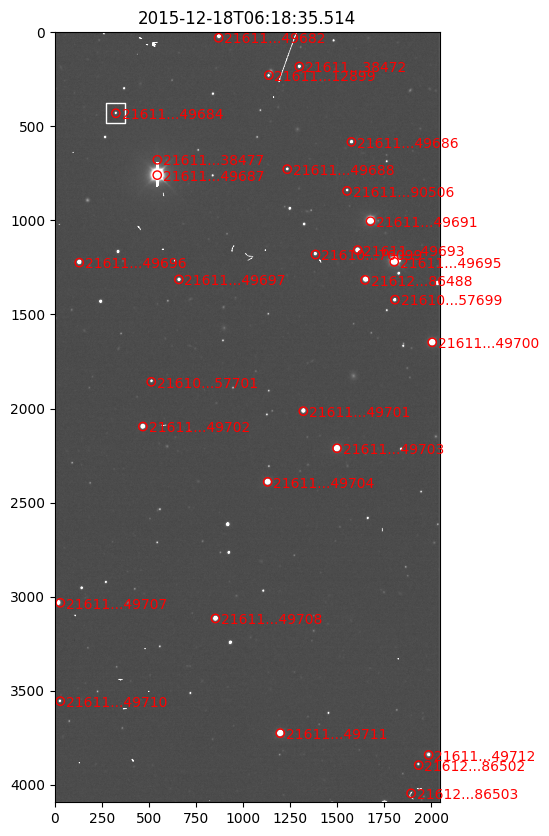

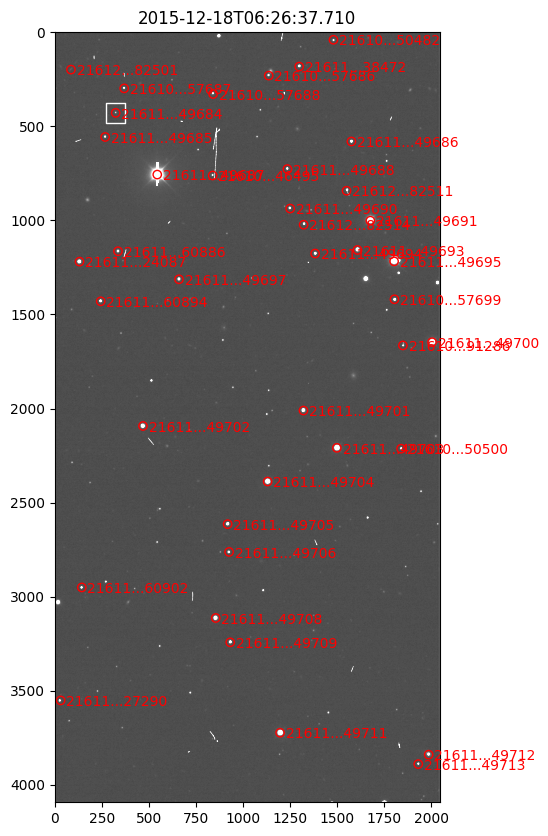

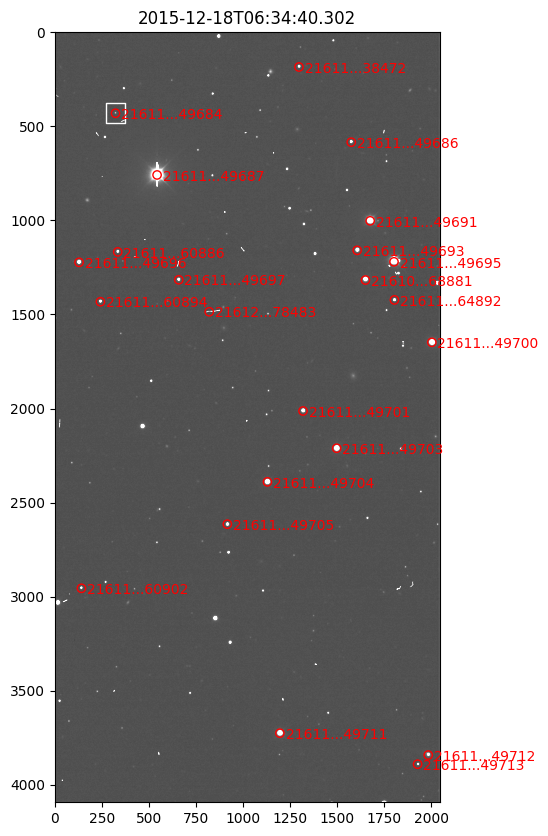

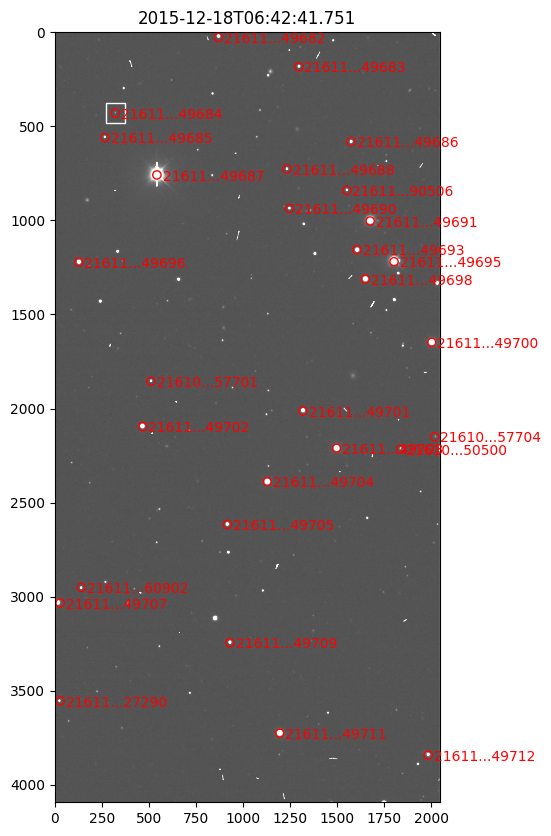

In [ ]:
times = []

for i, mjd in enumerate(data['midPointTai'].unique()):

    imname = imnames_timeordered[start:end][i]
    imnameS18 = imname[:-8] + '_S18' + imname[-8:]
    imdata = fits.getdata('dwfflare/dwfflareS18/' + imnameS18)
    header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
    exp_header = fits.getheader('dwfflare/' + imname)
    wcs = WCS(header)
    time = Time(header['DATE-OBS'])
    times.append(time)

    positions = np.array([data['x'][data['midPointTai'] == mjd], data['y'][data['midPointTai'] == mjd]]).T
    coords = np.array([data['ra'][data['midPointTai'] == mjd], data['decl'][data['midPointTai'] == mjd]]).T

    if i % 10 == 0:
        plt.figure(figsize=(20,10))
        plt.imshow(imdata, clim=(0,100), cmap='Greys_r')
        plt.scatter(flare_ref_pos[0]-1, flare_ref_pos[1]-1, marker='s', s=200, edgecolors='white', facecolors='None')
        plt.scatter(positions[:,0], positions[:,1], marker='o', facecolor='None', edgecolor='red')

        for j, p in enumerate(positions):
            plt.annotate('{0}...{1}'.format(str(data['diaObjectId'][data['midPointTai'] == mjd].values[j])[:5], 
                                            str(data['diaObjectId'][data['midPointTai'] == mjd].values[j])[-5:]), xy=p, xytext=p+30, color='r')
        plt.title('{}'.format(time))
        plt.show()

In [ ]:
flr_obj_id = 216116814394949684

In [ ]:
data[['x', 'y']][data['diaObjectId'] == flr_obj_id].mean()

x    322.631087
y    429.005162
dtype: float64

<AxesSubplot: xlabel='midPointTai', ylabel='x'>

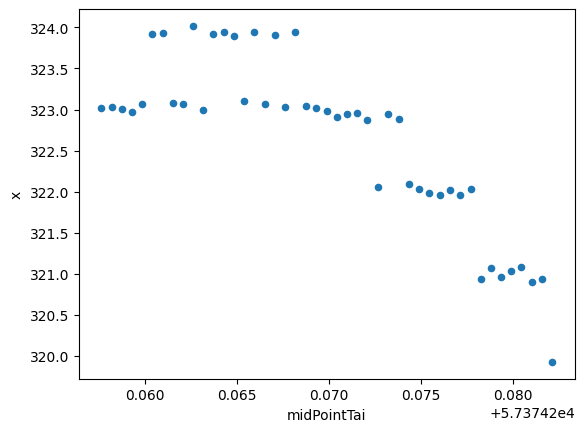

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='x', kind='scatter')

<AxesSubplot: xlabel='midPointTai', ylabel='y'>

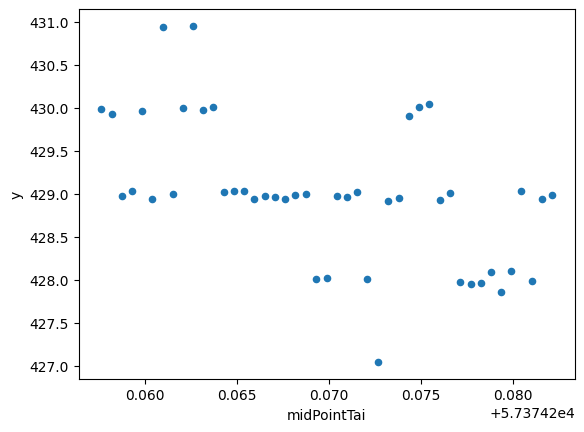

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='y', kind='scatter')

<AxesSubplot: xlabel='midPointTai', ylabel='ra'>

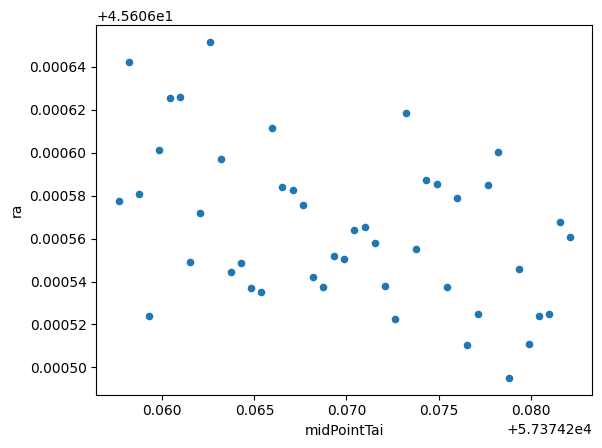

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='ra', kind='scatter')

<AxesSubplot: xlabel='midPointTai', ylabel='decl'>

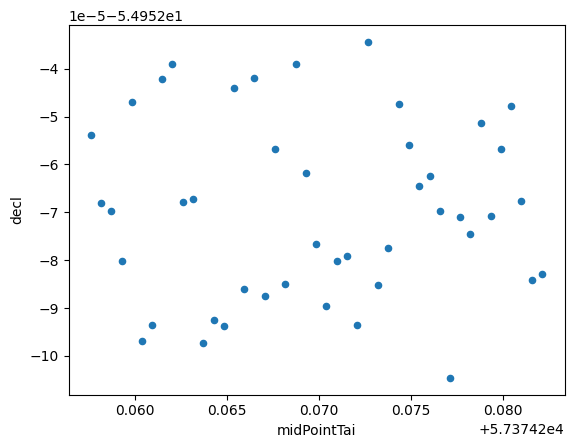

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='decl', kind='scatter')

In [ ]:
data['ra'][data['diaObjectId'] == flr_obj_id].shape

(45,)

In [ ]:
n_ids = data['diaObjectId'].unique().shape[0]
n_imgs = data['midPointTai'].unique().shape[0]
ref_cube = np.zeros((n_ids, 2, n_imgs))
ref_cube.shape

(158, 2, 74)

In [ ]:
for i, id in enumerate(data['diaObjectId'].unique()):

    for j, mjd in enumerate(data['midPointTai'].unique()):
        
        if data['ra'][ (data['midPointTai'] == mjd) * ((data['diaObjectId'] == id))].values:
            
            ra = data['ra'][ (data['midPointTai'] == mjd) * ((data['diaObjectId'] == id))].values
            dec = data['decl'][ (data['midPointTai'] == mjd) * ((data['diaObjectId'] == id))].values
            ref_cube[i,0,j] = ra
            ref_cube[i,1,j] = dec

        else:
            ref_cube[i,0,j] = np.nan
            ref_cube[i,1,j] = np.nan


In [ ]:
pa_arr = np.zeros((ref_cube.shape[0], ref_cube.shape[2]))

for i in range(ref_cube.shape[0]):
    for j in range(ref_cube.shape[2]):
        pa_arr[i][j] = celest_to_pa(ref_cube[i,0,j], ref_cube[i,1,j], time = times[j], loc = EarthLocation.of_site('Cerro Tololo'))

pa_arr.shape

(158, 74)

In [ ]:
shift_cube = np.zeros_like(ref_cube)
for t in range(ref_cube.shape[2]):
    shift_cube[:,:,t] = ref_cube[:,:,t] - ref_cube[:,:,0]

shift_cube.shape

(158, 2, 74)

In [ ]:
dpar_arr = np.zeros((shift_cube.shape[0], shift_cube.shape[2]))

for s in range(shift_cube.shape[0]):
    for t in range(shift_cube.shape[2]):
            dpar_arr[s][t] = dpar(shift_cube[s,0,t], shift_cube[s,1,t], pa_arr[s,t])

dpar_arr[:,0] = 0
dpar_arr.shape

(158, 74)

In [ ]:
dtan_arr = np.zeros((shift_cube.shape[0], shift_cube.shape[2]))

for s in range(shift_cube.shape[0]):
    for t in range(shift_cube.shape[2]):
        dtan_arr[s][t] = dtan(shift_cube[s,0,t], shift_cube[s,1,t], pa_arr[s,t])

dtan_arr[:,0] = 0
dtan_arr.shape

(158, 74)

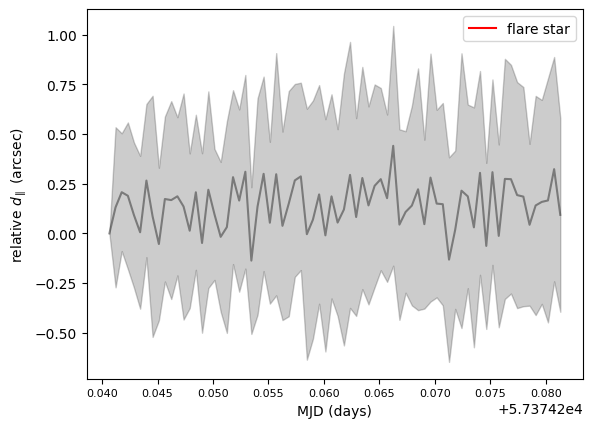

In [ ]:
plt.plot([time.mjd for time in times], dpar_arr[2] * 3600, color='red', label='flare star')

plt.plot([time.mjd for time in times], np.nanmean(dpar_arr, axis=0) * 3600, color='black', alpha=0.4)

plt.fill_between([time.mjd for time in times], (np.nanmean(dpar_arr, axis=0) - np.nanstd(dpar_arr, axis=0)) * 3600, 
                    (np.nanmean(dpar_arr, axis=0) + np.nanstd(dpar_arr, axis=0)) * 3600, color='black', alpha=0.2)

plt.tick_params(axis='x', labelsize=8)
plt.xlabel('MJD (days)')
plt.ylabel(r'relative $d_{\parallel}$ (arcsec)')
plt.legend()

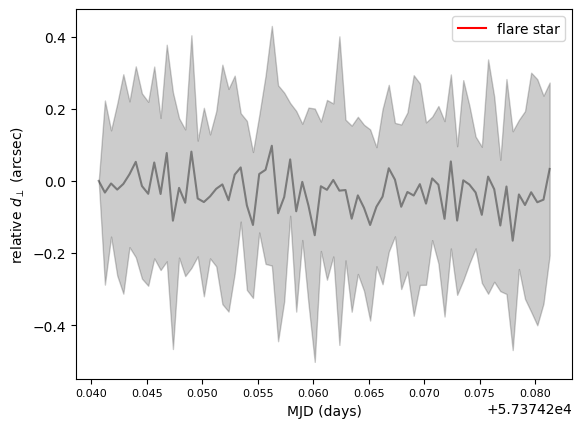

In [ ]:
plt.plot([time.mjd for time in times], dtan_arr[2] * 3600, color='red', label='flare star')

plt.plot([time.mjd for time in times], np.nanmean(dtan_arr, axis=0) * 3600, color='black', alpha=0.4)

plt.fill_between([time.mjd for time in times], (np.nanmean(dtan_arr, axis=0) - np.nanstd(dtan_arr, axis=0)) * 3600, 
                    (np.nanmean(dtan_arr, axis=0) + np.nanstd(dtan_arr, axis=0)) * 3600, color='black', alpha=0.2)

plt.tick_params(axis='x', labelsize=8)
plt.xlabel('MJD (days)')
plt.ylabel(r'relative $d_{\perp}$ (arcsec)')
plt.legend()

## DIAForcedSource

In [ ]:
data = pd.read_csv('dwfflare_rubin_v19/DiaForcedSource.csv')
data.head()

Unnamed: 0         diaObjectId  ccdVisitId        psFlux    psFluxErr  \
0           0  216116814394949682    50318617           NaN          NaN   
1           1  216116814394949683    50318617  2.838487e+03  2070.965585   
2           2  216116814394949684    50318617  2.032934e+06  4090.618486   
3           3  216116814394949685    50318617 -8.284671e+03  1672.641042   
4           4  216116814394949686    50318617  1.237628e+04  2254.356858   

             x           y  flags   diaForcedSourceId       totFlux  \
0   868.954407   27.625403      0  108058407197474817  4.621106e+05   
1  1295.570180  182.466275      0  108058407197474818  5.207813e+05   
2   322.972412  429.036285      0  108058407197474819  2.029639e+06   
3   267.831360  559.777100      0  108058407197474820  1.984969e+05   
4  1577.002441  579.197511      0  108058407197474821  6.584388e+05   

    totFluxErr   midPointTai  
0  1812.571480  57374.259291  
1  2032.570887  57374.259291  
2  3998.495626  57374.259291  
3  1627.456660  57374.259291  
4  2220.906779  57374.259291

In [ ]:
#time-sorting
data = data.sort_values('midPointTai')
data.head()

Unnamed: 0         diaObjectId  ccdVisitId        psFlux    psFluxErr  \
152         152  216116814394949689    50315417 -2.812871e+03  1214.890509   
185         185  216116814394949686    50315417 -1.547915e+04  2787.188301   
186         186  216103070499602481    50315417 -5.795761e+03  1060.813404   
187         187  216116814394949687    50315417  2.595122e+06  3936.266646   
188         188  216116814394949688    50315417 -8.743626e+03  1887.820861   

               x           y  flags   diaForcedSourceId       totFlux  \
152  1553.968385  837.284619      0  108051535249801217  1.260786e+05   
185  1575.155138  582.669958      0  108051535249801250  9.037000e+05   
186   542.812683  643.170654      0  108051535249801251  7.372755e+02   
187   542.607384  758.904686      0  108051535249801252  2.598885e+06   
188  1232.722317  727.090189      0  108051535249801253  3.600550e+05   

      totFluxErr   midPointTai  
152  1100.470137  57374.241476  
185  2595.803848  57374.241476  
186   933.405891  57374.241476  
187  3841.003930  57374.241476  
188  1713.481890  57374.241476

<AxesSubplot: xlabel='midPointTai', ylabel='totFlux'>

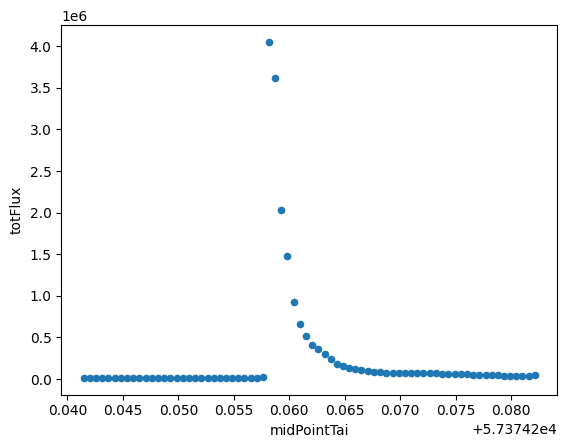

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='totFlux', kind='scatter')

<AxesSubplot: xlabel='midPointTai', ylabel='psFlux'>

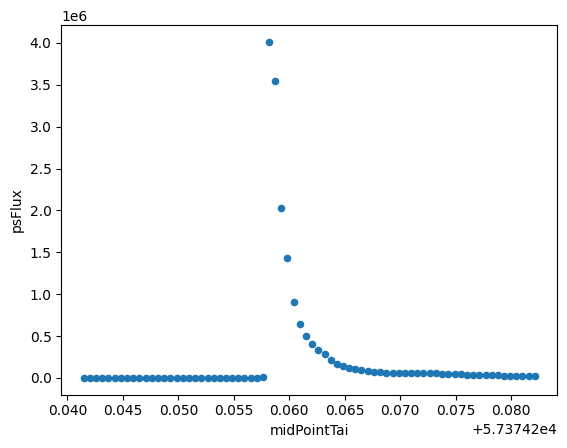

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='psFlux', kind='scatter')

<AxesSubplot: xlabel='midPointTai', ylabel='x'>

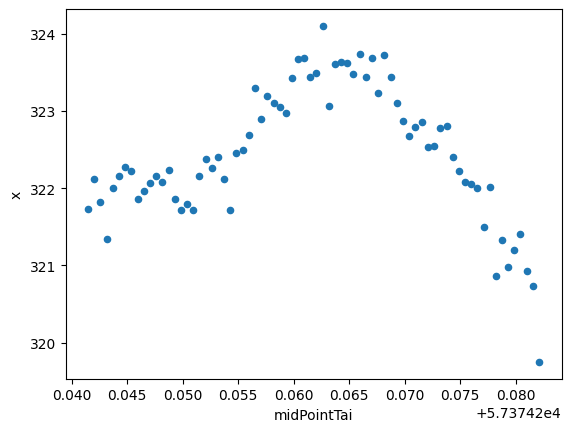

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='x', kind='scatter')

<AxesSubplot: xlabel='midPointTai', ylabel='y'>

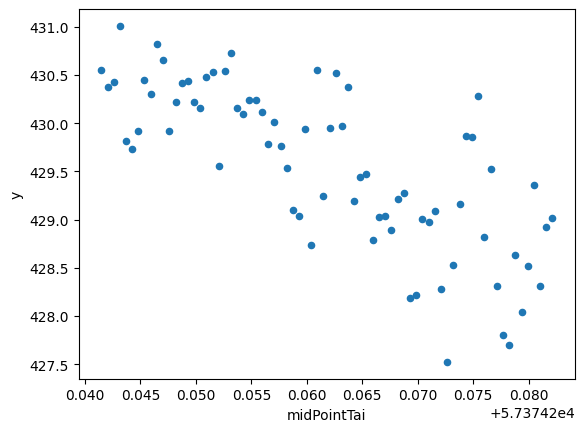

In [ ]:
data[data['diaObjectId'] == flr_obj_id].plot(x='midPointTai', y='y', kind='scatter')

In [ ]:
xpos = np.full((data['midPointTai'].unique().shape[0], data['diaObjectId'].unique().shape[0]), np.nan)
ypos = np.full((data['midPointTai'].unique().shape[0], data['diaObjectId'].unique().shape[0]), np.nan)

for i, t in enumerate(data['midPointTai'].unique()):
    for j, id in enumerate(data['diaObjectId'].unique()):
        
        if data['y'][ (data['midPointTai'] == t) * (data['diaObjectId'] == id)].values: 
            ypos[i,j] = data['y'][ (data['midPointTai'] == t) * (data['diaObjectId'] == id)].values[0]

        else:
            pass

for i, t in enumerate(data['midPointTai'].unique()):
    for j, id in enumerate(data['diaObjectId'].unique()):
        
        if data['x'][ (data['midPointTai'] == t) * (data['diaObjectId'] == id)].values: 
            xpos[i,j] = data['x'][ (data['midPointTai'] == t) * (data['diaObjectId'] == id)].values[0]

        else:
            pass

In [ ]:
dxpos = xpos - xpos[0,:]
dypos = ypos - ypos[0,:]
dypos.shape

(74, 158)

In [ ]:
flr_ind = np.where(data['diaObjectId'].unique() == flr_obj_id)[0][0]
flr_ind

In [ ]:
plt.plot(data['midPointTai'].unique(), np.nanmean([dxpos[:,i] for i in range(dxpos.shape[1]) if i != flr_ind], axis=0), color='k', alpha=0.6)
plt.fill_between(data['midPointTai'].unique(), 
                np.nanmean([dxpos[:,i] for i in range(dxpos.shape[1]) if i != flr_ind], axis=0) - np.nanstd([dxpos[:,i] for i in range(dxpos.shape[1]) if i != flr_ind], axis=0),
                np.nanmean([dxpos[:,i] for i in range(dxpos.shape[1]) if i != flr_ind], axis=0) + np.nanstd([dxpos[:,i] for i in range(dxpos.shape[1]) if i != flr_ind], axis=0), color='k', alpha=0.2)

plt.plot(data['midPointTai'].unique(), dxpos[:,flr_ind], color='steelblue', label='flare star')

plt.xlabel('midPointTai')
plt.ylabel(r'$\Delta$x (pixel)')
plt.title('Rubin diaForcedSource')
plt.legend();

NameError: name 'flr_ind' is not defined

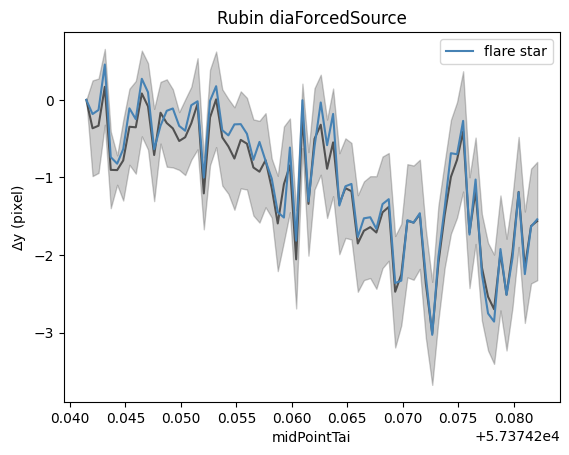

In [ ]:
plt.plot(data['midPointTai'].unique(), np.nanmean([dypos[:,i] for i in range(dypos.shape[1]) if i != flr_ind], axis=0), color='k', alpha=0.6)
plt.fill_between(data['midPointTai'].unique(), 
                np.nanmean([dypos[:,i] for i in range(dypos.shape[1]) if i != flr_ind], axis=0) - np.nanstd([dypos[:,i] for i in range(dypos.shape[1]) if i != flr_ind], axis=0),
                np.nanmean([dypos[:,i] for i in range(dypos.shape[1]) if i != flr_ind], axis=0) + np.nanstd([dypos[:,i] for i in range(dypos.shape[1]) if i != flr_ind], axis=0), color='k', alpha=0.2)

plt.plot(data['midPointTai'].unique(), dypos[:,flr_ind], color='steelblue', label='flare star')

plt.xlabel('midPointTai')
plt.ylabel(r'$\Delta$y (pixel)')
plt.title('Rubin diaForcedSource')
plt.legend();

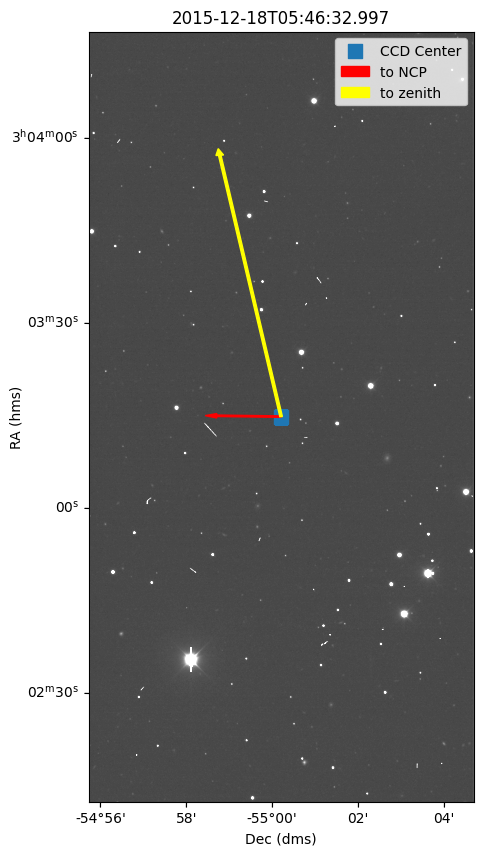

In [ ]:
imname = imnames_timeordered[start]
imnameS18 = imname[:-8] + '_S18' + imname[-8:]
imdata = fits.getdata('dwfflare/dwfflareS18/' + imnameS18)
header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
wcs = WCS(header)
time = Time(header['DATE-OBS'], format='fits')

mtn = EarthLocation.of_site('Cerro Tololo')

zenith = SkyCoord(AltAz(alt=90 * u.degree, az=0 * u.degree, obstime = time, location=mtn)).transform_to(ICRS())
ccdcenter = SkyCoord(ra = header['RA1'], dec = header['DEC1'], unit=(u.hourangle, u.deg))
pa = celest_to_pa(ccdcenter.ra.deg, ccdcenter.dec.deg, time, loc=mtn)

fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': wcs})
ax.imshow(imdata, clim=(0,100), cmap='Greys_r')
ax.set_title('{}'.format(time))
ax.scatter(ccdcenter.ra, ccdcenter.dec, marker='s', s=100, transform = ax.get_transform('icrs'), label='CCD Center')
ax.arrow(x=ccdcenter.ra.value, y=ccdcenter.dec.value, dx=0, dy=0.025, color='red', transform = ax.get_transform('icrs'), label='to NCP')
ax.arrow(x=ccdcenter.ra.value, y=ccdcenter.dec.value, dx=0.025 * np.tan(np.deg2rad(pa)), dy=0.025, color='yellow', transform = ax.get_transform('icrs'), label='to zenith')
ax.legend()

lon, lat = ax.coords
lon.set_ticks()
lon.set_ticks_position('lb')
lon.set_ticklabel_position('lb')
lon.set_axislabel('Dec (dms)')
lat.set_ticks()
lat.set_ticks_position('lb')
lat.set_ticklabel_position('lb')
lat.set_axislabel('RA (hms)', minpad=-0.4)

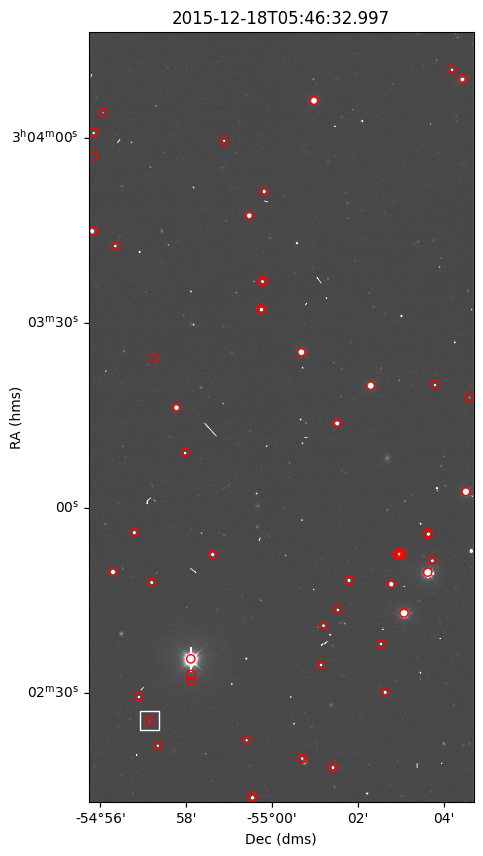

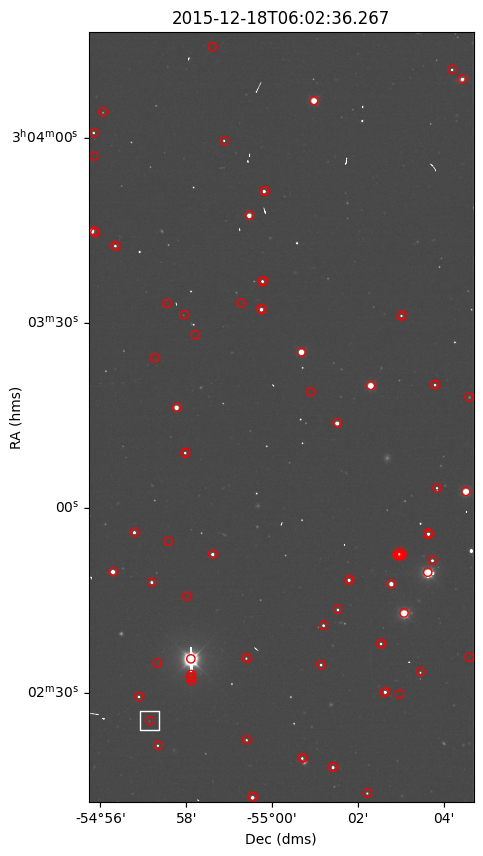

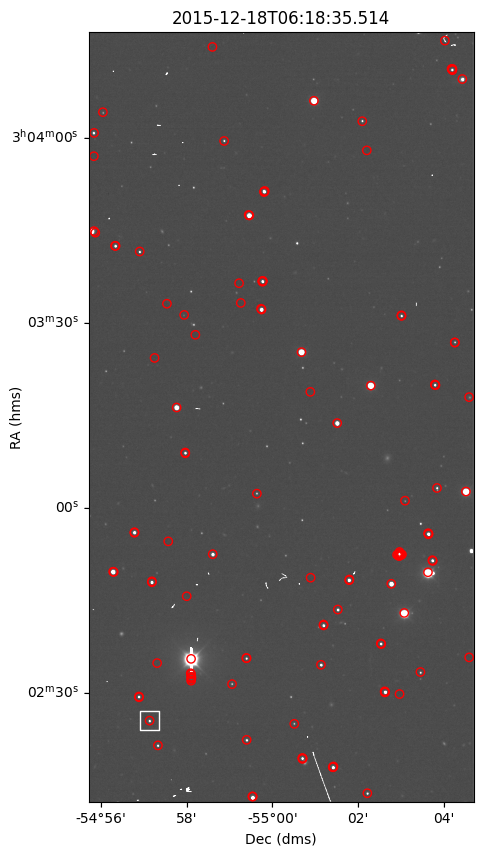

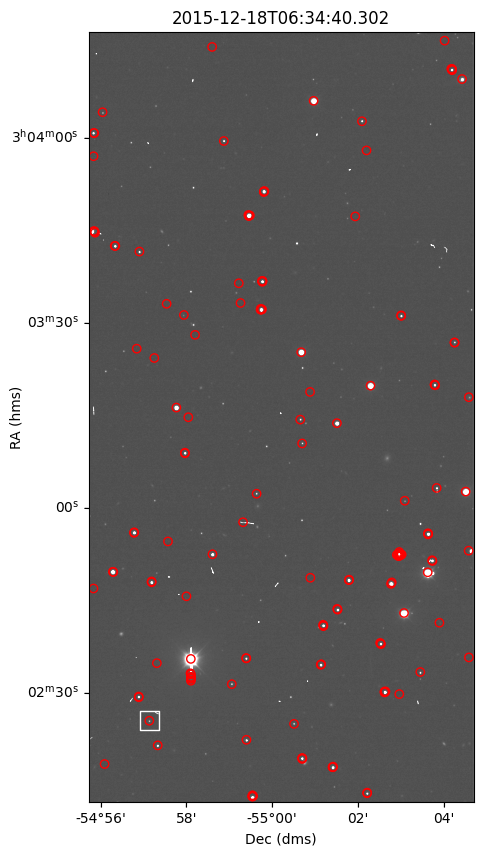

In [ ]:
times = []
plot = True
n_ids = data['diaObjectId'].unique().shape[0]
n_imgs = data['midPointTai'].unique().shape[0]
ref_cube = np.full((n_ids, 2, n_imgs), np.nan)

for i, mjd in enumerate(data['midPointTai'].unique()):

    imname = imnames_timeordered[start:end][i]
    imnameS18 = imname[:-8] + '_S18' + imname[-8:]
    imdata = fits.getdata('dwfflare/dwfflareS18/' + imnameS18)
    header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
    exp_header = fits.getheader('dwfflare/' + imname)
    wcs = WCS(header)
    time = Time(header['DATE-OBS'])
    times.append(time)

    positions = np.array([data['x'][data['midPointTai'] == mjd], data['y'][data['midPointTai'] == mjd]]).T
    coords = wcs.all_pix2world(positions, 1)

    id_inds = []

    for id in data['diaObjectId'][data['midPointTai'] == mjd]:

        id_inds.append(np.where(id == data['diaObjectId'].unique())[0][0])

    ref_cube[id_inds, 0, i] = coords[:,0]
    ref_cube[id_inds, 1, i] = coords[:,1]

    if plot:
        if i % 20 == 0:

            fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': wcs})
            ax.imshow(imdata, clim=(0,100), cmap='Greys_r')
            ax.scatter(flare_ref_pos[0], flare_ref_pos[1], marker='s', s=200, edgecolors='white', facecolors='None')
            #ax.scatter(positions[:,0], positions[:,1], marker='o', facecolor='None', edgecolor='red')
            ax.scatter(ref_cube[:,0,i] * u.deg, ref_cube[:,1,i] * u.deg, transform = ax.get_transform('icrs'), 
                       marker='o', facecolor='None', edgecolor='red')
            #print(positions.shape[0])
            ax.set_title('{}'.format(time))

            lon, lat = ax.coords
            lon.set_ticks()
            lon.set_ticks_position('lb')
            lon.set_ticklabel_position('lb')
            lon.set_axislabel('Dec (dms)')
            lat.set_ticks()
            lat.set_ticks_position('lb')
            lat.set_ticklabel_position('lb')
            lat.set_axislabel('RA (hms)', minpad=-0.4)
            plt.show()

In [ ]:
celest_to_pa(ccdcenter.ra.deg, ccdcenter.dec.deg, time, loc=mtn)

81.92739093286532

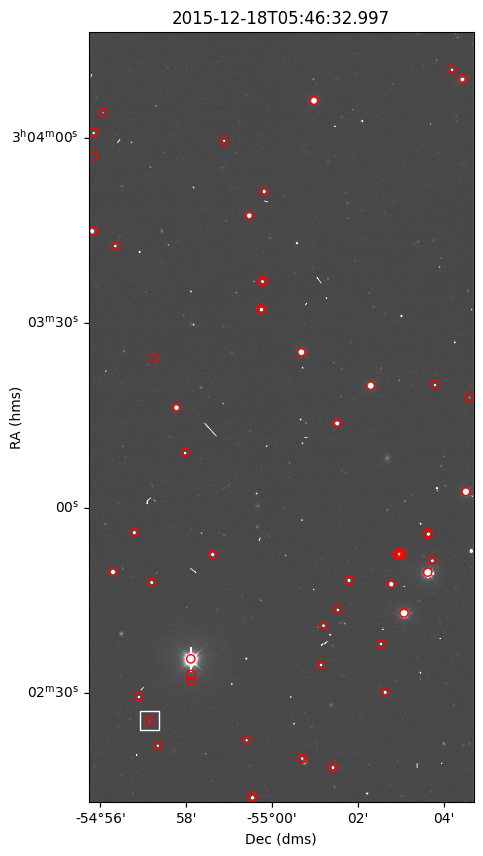

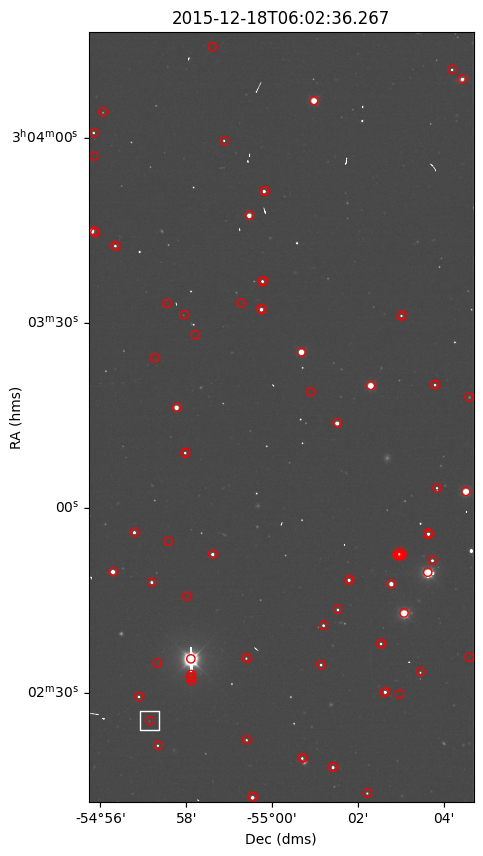

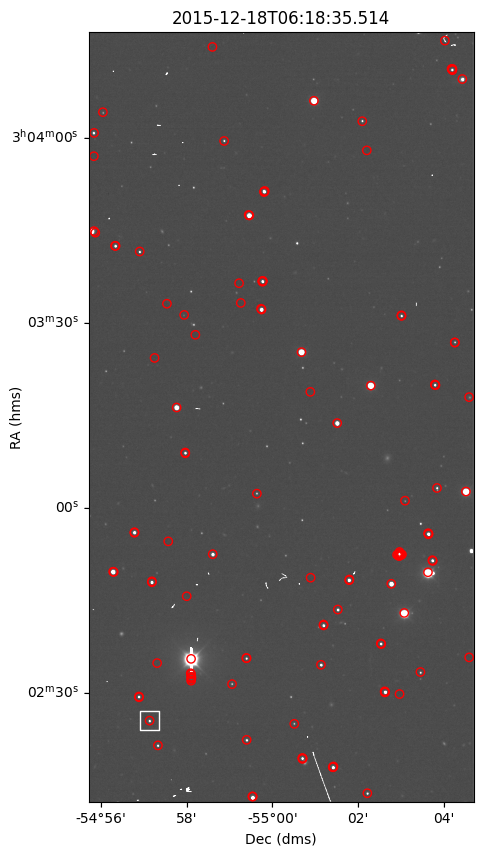

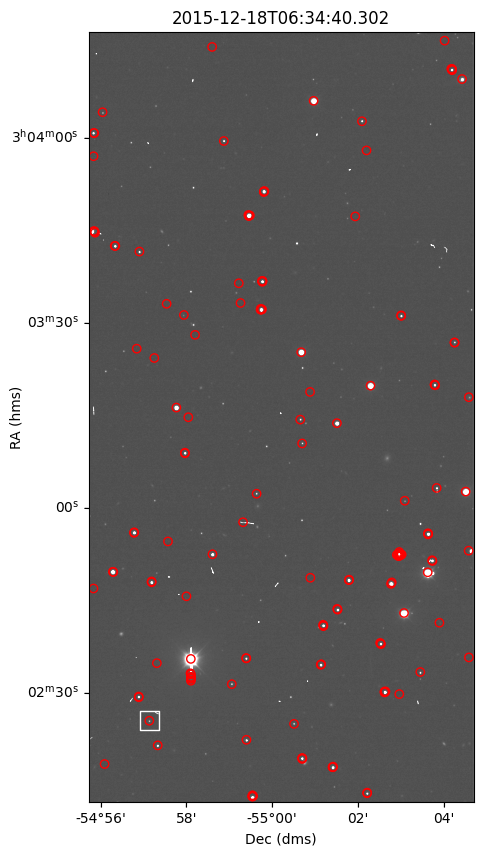

In [ ]:
times = []
plot = True
n_ids = data['diaObjectId'].unique().shape[0]
n_imgs = data['midPointTai'].unique().shape[0]
ref_cube = np.full((n_ids, 2, n_imgs), np.nan)

for i, mjd in enumerate(data['midPointTai'].unique()):

    imname = imnames_timeordered[start:end][i]
    imnameS18 = imname[:-8] + '_S18' + imname[-8:]
    imdata = fits.getdata('dwfflare/dwfflareS18/' + imnameS18)
    header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
    exp_header = fits.getheader('dwfflare/' + imname)
    wcs = WCS(header)
    time = Time(header['DATE-OBS'])
    times.append(time)

    positions = np.array([data['x'][data['midPointTai'] == mjd], data['y'][data['midPointTai'] == mjd]]).T
    coords = wcs.all_pix2world(positions, 1)

    id_inds = []

    for id in data['diaObjectId'][data['midPointTai'] == mjd]:

        id_inds.append(np.where(id == data['diaObjectId'].unique())[0][0])

    ref_cube[id_inds, 0, i] = coords[:,0]
    ref_cube[id_inds, 1, i] = coords[:,1]

    if plot:
        if i % 20 == 0:

            fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': wcs})
            ax.imshow(imdata, clim=(0,100), cmap='Greys_r')
            ax.scatter(flare_ref_pos[0], flare_ref_pos[1], marker='s', s=200, edgecolors='white', facecolors='None')
            #ax.scatter(positions[:,0], positions[:,1], marker='o', facecolor='None', edgecolor='red')
            ax.scatter(ref_cube[:,0,i] * u.deg, ref_cube[:,1,i] * u.deg, transform = ax.get_transform('icrs'), 
                       marker='o', facecolor='None', edgecolor='red')
            #print(positions.shape[0])
            ax.set_title('{}'.format(time))

            lon, lat = ax.coords
            lon.set_ticks()
            lon.set_ticks_position('lb')
            lon.set_ticklabel_position('lb')
            lon.set_axislabel('Dec (dms)')
            lat.set_ticks()
            lat.set_ticks_position('lb')
            lat.set_ticklabel_position('lb')
            lat.set_axislabel('RA (hms)', minpad=-0.4)
            plt.show()

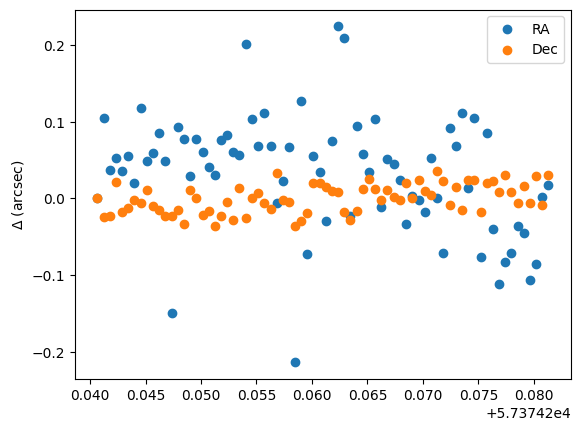

In [ ]:
plt.scatter([time.mjd for time in times], (ref_cube[flr_ind,0,:] - ref_cube[flr_ind,0,0]) * 3600, label='RA')
plt.scatter([time.mjd for time in times], (ref_cube[flr_ind,1,:] - ref_cube[flr_ind,1,0]) * 3600, label='Dec')
plt.ylabel(r'$\Delta$ (arcsec)')
plt.legend()

In [ ]:
ref_cube.shape

(158, 2, 74)

In [ ]:
pa_arr = np.zeros((ref_cube.shape[0], ref_cube.shape[2]))

for i in range(ref_cube.shape[0]):
    for j in range(ref_cube.shape[2]):
        pa_arr[i][j] = celest_to_pa(ref_cube[i,0,j], ref_cube[i,1,j], time = times[j], loc = EarthLocation.of_site('Cerro Tololo'))

pa_arr.shape

(158, 74)

In [ ]:
shift_cube = np.zeros_like(ref_cube)
for t in range(ref_cube.shape[2]):
    shift_cube[:,:,t] = ref_cube[:,:,t] - ref_cube[:,:,0]

shift_cube.shape

(158, 2, 74)

In [ ]:
dpar_arr = np.zeros((shift_cube.shape[0], shift_cube.shape[2]))

for s in range(shift_cube.shape[0]):
    for t in range(shift_cube.shape[2]):
            dpar_arr[s][t] = dpar(shift_cube[s,0,t], shift_cube[s,1,t], pa_arr[s,t])

dpar_arr[:,0] = 0
dpar_arr.shape

(158, 74)

In [ ]:
dtan_arr = np.zeros((shift_cube.shape[0], shift_cube.shape[2]))

for s in range(shift_cube.shape[0]):
    for t in range(shift_cube.shape[2]):
        dtan_arr[s][t] = dtan(shift_cube[s,0,t], shift_cube[s,1,t], pa_arr[s,t])

dtan_arr[:,0] = 0
dtan_arr.shape

(158, 74)

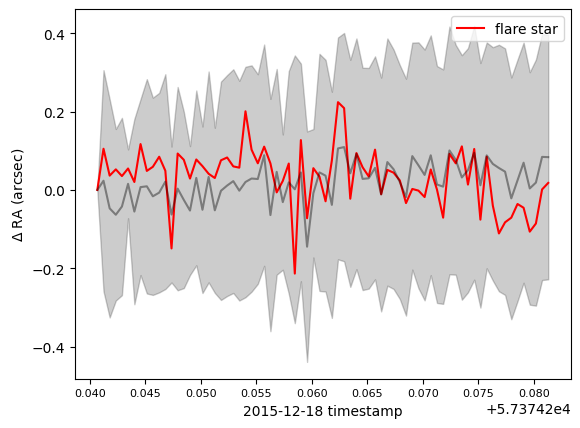

In [ ]:
plt.plot([time.mjd for time in times], shift_cube[flr_ind,0,:] * 3600, color='red', label='flare star')

plt.plot([time.mjd for time in times], np.nanmean([shift_cube[i,0,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0) * 3600, color='black', alpha=0.4)

plt.fill_between([time.mjd for time in times], 
                 (np.nanmean([shift_cube[i,0,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0) - 
                  np.nanstd([shift_cube[i,0,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0)) * 3600, 
                 (np.nanmean([shift_cube[i,0,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0) + 
                  np.nanstd([shift_cube[i,0,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0)) * 3600, color='black', alpha=0.2)

plt.tick_params(axis='x', labelsize=8)
plt.xlabel('{} timestamp'.format(times[0].value[:10]))
plt.ylabel(r'$\Delta$ RA (arcsec)')
plt.legend()

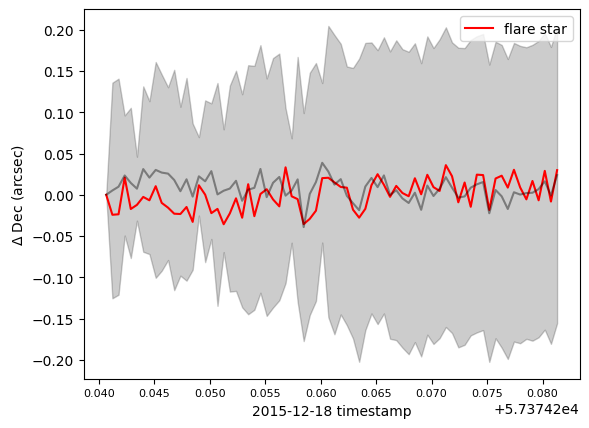

In [ ]:
plt.plot([time.mjd for time in times], shift_cube[flr_ind,1,:] * 3600, color='red', label='flare star')

plt.plot([time.mjd for time in times], np.nanmean([shift_cube[i,1,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0) * 3600, color='black', alpha=0.4)

plt.fill_between([time.mjd for time in times], 
                 (np.nanmean([shift_cube[i,1,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0) - 
                  np.nanstd([shift_cube[i,1,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0)) * 3600, 
                 (np.nanmean([shift_cube[i,1,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0) + 
                  np.nanstd([shift_cube[i,1,:] for i in range(shift_cube.shape[0]) if i != flr_ind], axis=0)) * 3600, color='black', alpha=0.2)

plt.tick_params(axis='x', labelsize=8)
plt.xlabel('{} timestamp'.format(times[0].value[:10]))
plt.ylabel(r'$\Delta$ Dec (arcsec)')
plt.legend()

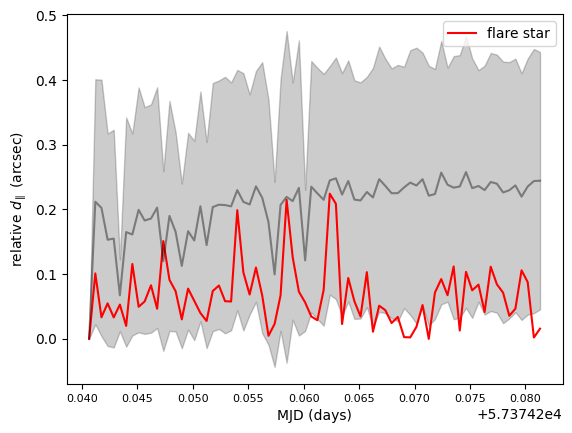

In [ ]:
plt.plot([time.mjd for time in times], dpar_arr[flr_ind] * 3600, color='red', label='flare star')

plt.plot([time.mjd for time in times], np.nanmean(dpar_arr, axis=0) * 3600, color='black', alpha=0.4)

plt.fill_between([time.mjd for time in times], (np.nanmean(dpar_arr, axis=0) - np.nanstd(dpar_arr, axis=0)) * 3600, 
                    (np.nanmean(dpar_arr, axis=0) + np.nanstd(dpar_arr, axis=0)) * 3600, color='black', alpha=0.2)

plt.tick_params(axis='x', labelsize=8)
plt.xlabel('MJD (days)')
plt.ylabel(r'relative $d_{\parallel}$ (arcsec)')
plt.legend()

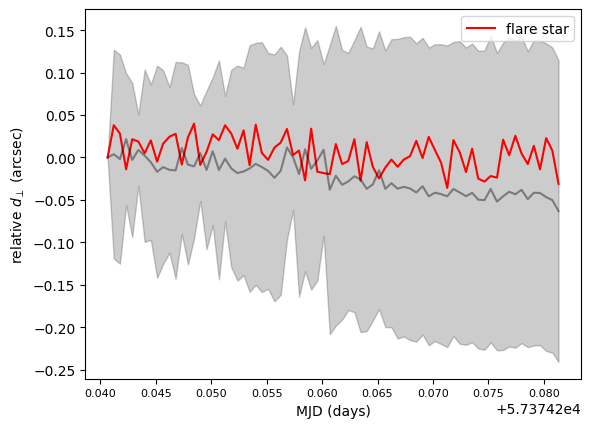

In [ ]:
plt.plot([time.mjd for time in times], dtan_arr[flr_ind] * 3600, color='red', label='flare star')

plt.plot([time.mjd for time in times], np.nanmean(dtan_arr, axis=0) * 3600, color='black', alpha=0.4)

plt.fill_between([time.mjd for time in times], (np.nanmean(dtan_arr, axis=0) - np.nanstd(dtan_arr, axis=0)) * 3600, 
                    (np.nanmean(dtan_arr, axis=0) + np.nanstd(dtan_arr, axis=0)) * 3600, color='black', alpha=0.2)

plt.tick_params(axis='x', labelsize=8)
plt.xlabel('MJD (days)')
plt.ylabel(r'relative $d_{\perp}$ (arcsec)')
plt.legend()